# Aprendizado por reforço - Métodos QLearning e Monte Carlo

In [ ]:
!pip install gymnasium
!pip install gymnasium[toy_text]
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.6 MB/s eta 0:00:00


# Implementação do método QLearning

In [ ]:
#@title Rendering elements
# rendering libs
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.init()
screen = pygame.display.set_mode((144,16))

# rendering function
def render(env):
    # render the environment
    # env.render_mode = 'human'
    env.render()
    # env.render_mode = 'ansi'

    # convert image so it can be displayed in OpenCV
    view = pygame.surfarray.array3d(screen)

    # convert from (width, height, channel) to (height, width, channel)
    view = view.transpose([1, 0, 2])

    # convert from rgb to bgr
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

    # display image, clear cell when new frame is ready
    cv2_imshow(img_bgr)
    output.clear(wait=True)

In [ ]:
frozen_env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="human")

In [ ]:
descFrozenLake=[
  "SFFFFFFFHFFFFFFF",
  "FFHFFFFFFFHFFFFF",
  "FFFFHFFFFFFFFFHF",
  "FFHFFFHFFHFFFFFF",
  "FFHFFFHFFFFHHHHH",
  "FFFFHFFFHHFFFFFF",
  "HFFFFFFFFFFFHFFF",
  "FFFFFHHHHFFHFFHF",
  "FFFHFFFFFFFHFHFF",
  "FFFFHFFHFHFHFFFH",
  "FFFFFHFFFFFFFHFF",
  "FFFFFFFFHFFFHFFH",
  "HFFFFFFFFHFHFFFF",
  "FFFFFFFFFHFFFHFF",
  "FHHHHHHHHHHHHHFF",
  "FFFFFFFFFFFFFFFG"]

In [ ]:
frozen_env = gym.make('FrozenLake-v1', desc=descFrozenLake, is_slippery=True, render_mode="human")


O ambiente pode ser reiniciado com a função `reset`. Podemos imprimir o estado atual do ambiente com a função `render`.

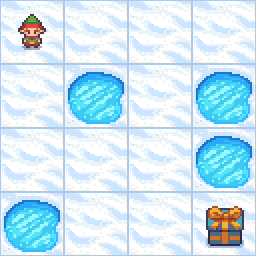

In [ ]:
frozen_env.reset()
render(frozen_env)

Para simular a tomada de decisões de forma aleatória, basta fazer o seguinte.

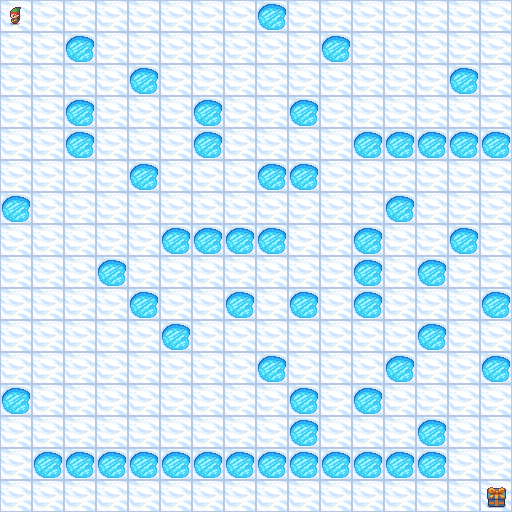

In [ ]:
frozen_env.reset()
for step in range(5):
  _ = frozen_env.step(np.random.randint(4))
  render(frozen_env)

# Episodio 1 - Ambiente 4x4

In [ ]:
class QLearner:

    def __init__(self, environment_name='FrozenLake-v1'):

        self.__environment_name = environment_name
        self.__environment = gym.make(self.__environment_name, desc=None, map_name="4x4", render_mode="ansi", is_slippery=False)
        #self.__environment = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="ansi", is_slippery=False)

        # initializing the Q-table
        self.__Q = []

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

    # train the Q-learning agent
    def train(self, num_episodes=100, num_steps=100, alpha=0.3, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0, min_epsilon=0.0):

        # initializing the Q-table
        self.__Q = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

        # episodes
        for episode in range(num_episodes):

            # reset the environment to start a new episode
            state, info = self.__environment.reset()

            # reward accumulated along episode
            accumulated_reward = 0

            # steps within current episode
            for step in range(num_steps):

                # epsilon-greedy action selection
                # exploit with probability 1-epsilon
                if np.random.uniform(0, 1) > epsilon:
                    action = np.argmax(self.__Q[state,:])

                # explore with probability epsilon
                else:
                    action = self.__environment.action_space.sample()

                # perform the action and observe the new state and corresponding reward
                new_state, reward, terminated, truncated, info = self.__environment.step(action)

                # Ajustes de recompensas
                # Verificar se o novo estado é um buraco (por exemplo, usando a informação 'done' do ambiente)
                if terminated and reward == 0:
                    # Se caiu no buraco, ajuste a recompensa para -50
                    reward = -10
                elif terminated and reward == 1:
                    # Atinjingo o objetivo, a recompensa é 100
                    reward = 10
                else:
                    # Caso contrário, configure a recompensa para -1 a cada passo
                    reward = -1

                # update the Q-table
                self.__Q[state, action] = self.__Q[state, action] + alpha * (reward + gamma * np.max(self.__Q[new_state, :]) - self.__Q[state, action])

                # update the accumulated reward
                accumulated_reward += reward

                # update the current state
                state = new_state

                # end the episode when it is done
                if terminated or truncated:
                    break

            # decay exploration rate to ensure that the agent exploits more as it becomes experienced
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*episode)

            # update the lists of rewards and epsilons
            self.__rewards.append(accumulated_reward)
            self.__epsilons.append(epsilon)

        # return the list of accumulated reward along episodes
        print("Tabela Q:")
        print("[esq, dir, cima, baixo]")
        print(self.__Q)

        return self.__rewards


    # run the Q-learning agent greedily w.r.t. its Q-values
    def run_greedily(self, num_steps=100):

        env = gym.make(self.__environment_name, desc=None, map_name="4x4", render_mode="human", is_slippery=False)
        #env = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="human", is_slippery=False)

        # reset the environment to start a new episode
        state, info = env.reset()

        # reward accumulated along episode
        accumulated_reward = 0

        # steps within current episode
        for step in range(num_steps):

            # act greedily
            action = np.argmax(self.__Q[state,:])

            # perform the action and observe the new state and corresponding reward
            new_state, reward, terminated, truncated, info = env.step(action)

            # update the accumulated reward
            accumulated_reward += reward

            # update the current state
            state = new_state

            # render the environment
            render(env)

            # end the episode when it is done
            if terminated or truncated:
                break

        # return accumulated reward
        return accumulated_reward


Inicialização do QLearner e inicio do treinamento.

In [ ]:
#0,1/0,1  0,5/0,1   0,9/0,1
#0,1/0,5  0,5/0,5   0,9/0,5
#0,1/0,9  0,5/0,9   0,9/0,9

num_episodes=100
num_steps=20

alpha=0.5 #taxa de aprendizado 0, 0.1, 0.3, 0.5, 1 #Cenarios: 0,1 , 0,5 , 0,9
gamma=0.9 #fator de desconto #Cenarios: 0,1 , 0,5 , 0,9

epsilon=1 #taxa de exploração inicia
decay_epsilon=0.01 #taxa de decaimento da taxa de exploração (ex 0.1 indica que a cada interação o epsilon decai 10%)
min_epsilon=0

# instantiate the Q-learner
ql = QLearner('FrozenLake-v1')

# train the Q-learner
rewards = ql.train(num_episodes, num_steps, alpha, gamma, epsilon, decay_epsilon, min_epsilon)

# print results
print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
print ("Average reward (last 100 episodes): " + str(sum(rewards[-100:])/100))

Tabela Q:
[esq, dir, cima, baixo]
[[-3.01662704  1.8098     -3.03840372 -3.20040001]
 [-2.56357852 -5.         -2.24529258 -2.64908109]
 [-2.04802344  0.24462891 -2.24969062 -2.06928125]
 [-2.33882422 -5.         -2.26219063 -2.26219063]
 [-2.64908109  3.122      -5.         -2.69563727]
 [ 0.          0.          0.          0.        ]
 [-5.          4.38847656 -5.         -1.4925    ]
 [ 0.          0.          0.          0.        ]
 [-1.8549375  -5.          4.58       -2.29502914]
 [-1.18875    -1.1         6.2        -5.        ]
 [-1.0875      8.         -5.         -0.8375    ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-5.         -0.975       2.625      -0.725     ]
 [-0.5        -0.5        10.          0.        ]
 [ 0.          0.          0.          0.        ]]
Average reward (all episodes): 2.28
Average reward (last 100 episodes): 2.28


Avaliação do desempenho do algoritmo, através de um gráfico da recompensa total por episódio.

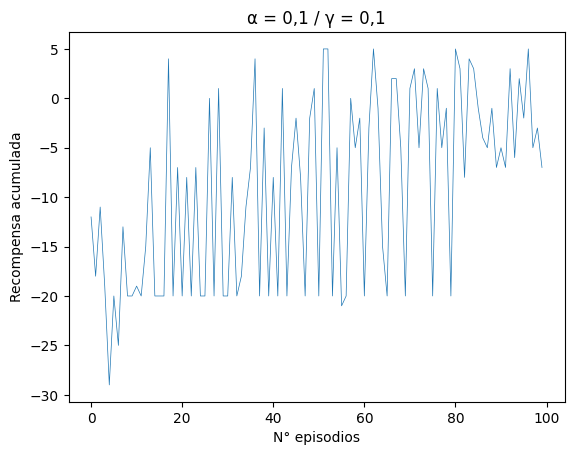

In [ ]:
#0,1/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,1')
plt.show()

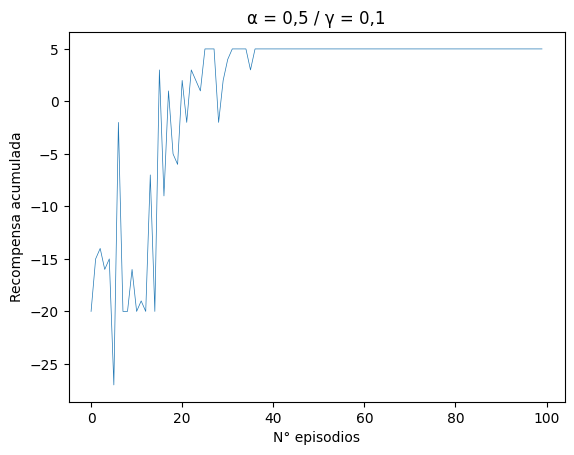

In [ ]:
#0,5/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,1')
plt.show()

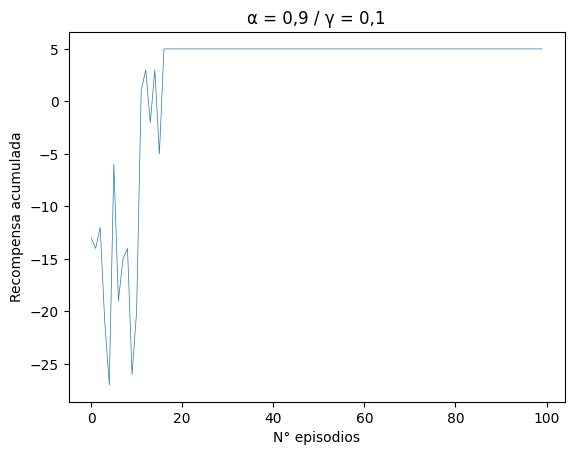

In [ ]:
#0,9/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,1')
plt.show()

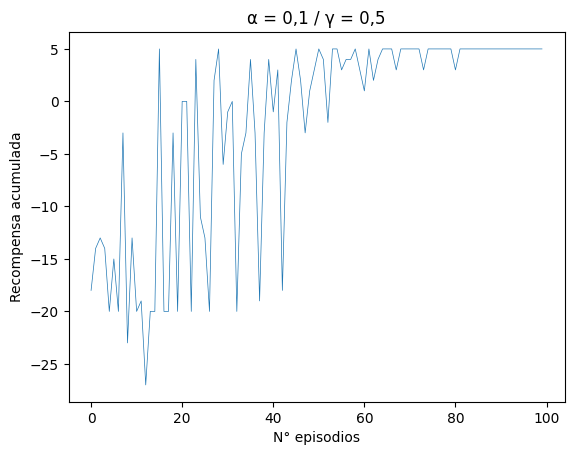

In [ ]:
#0,1/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,5')
plt.show()

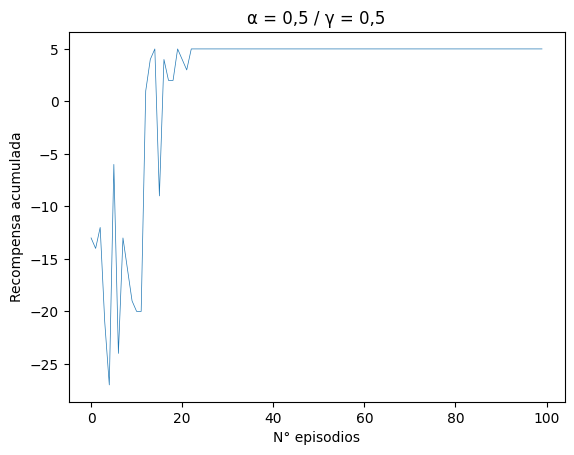

In [ ]:
#0,5/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,5')
plt.show()

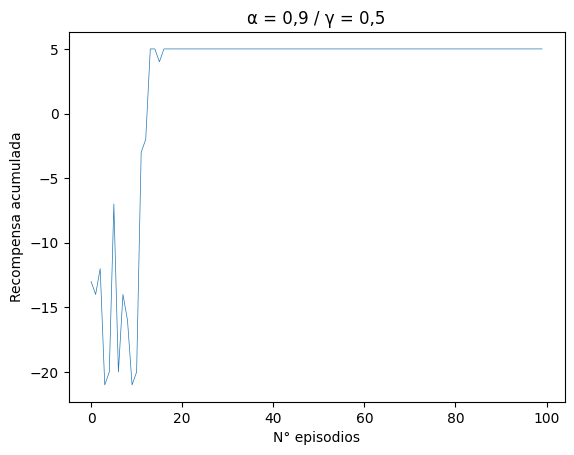

In [ ]:
#0,9/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,5')
plt.show()

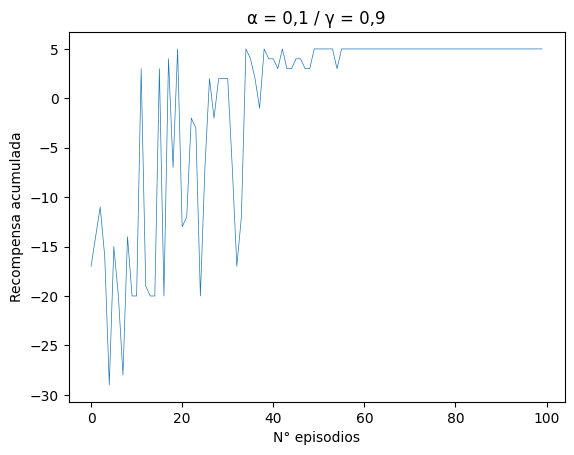

In [ ]:
#0,1/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,9')
plt.show()

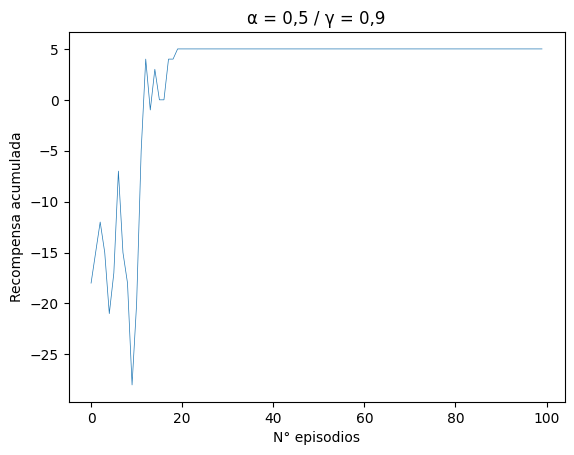

In [ ]:
#0,5/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,9')
plt.show()

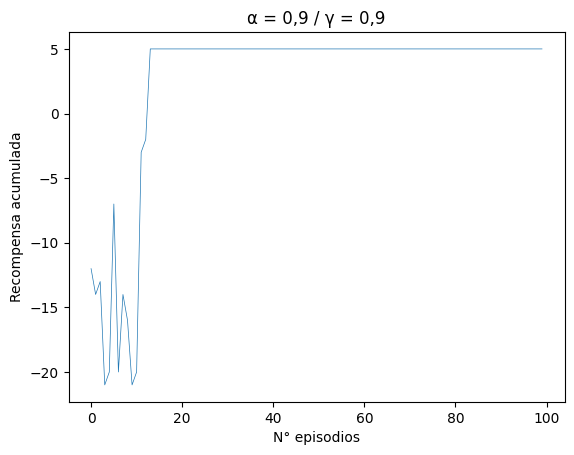

In [ ]:
#0,9/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,9')
plt.show()

Para visualizar o agente atuando de forma gulosa em relação aos valores Q, basta executar o código abaixo.

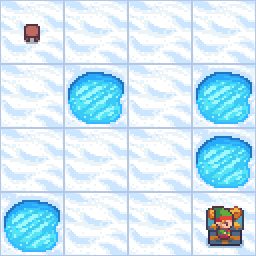

In [ ]:
reward = ql.run_greedily()

Aplicação método de Monte Carlo

In [ ]:
class MonteCarlo:

    def __init__(self, environment_name='FrozenLake-v1'):

        self.__environment_name = environment_name
        self.__environment = gym.make(self.__environment_name, desc=None, map_name="4x4", render_mode="ansi", is_slippery=False)
        #self.__environment = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="ansi", is_slippery=False)

        # initializing the Q-table
        self.__Q = []

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

    def train(self, num_episodes=100, num_steps=100, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0, min_epsilon=0.01):
        # Initialize the Q-table for the target policy
        self.__Q = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # Initialize C(s, a), which is the cumulative sum of importance sampling ratios
        C = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # Initialize the list to store cumulative rewards
        self.__rewards = []

        # Main loop for episodes
        for episode in range(num_episodes):
            state, _ = self.__environment.reset()
            accumulated_reward = 0
            trajectory = []

            # Step within the episode
            for step in range(num_steps):
                # epsilon-greedy action selection
                # exploit with probability 1-epsilon
                if np.random.uniform(0, 1) > epsilon:
                    action = np.argmax(self.__Q[state,:])

                # explore with probability epsilon
                else:
                    action = self.__environment.action_space.sample()

                new_state, reward, terminated, truncated, info = self.__environment.step(action)

                # Ajustes de recompensas
                # Verificar se o novo estado é um buraco
                if terminated and reward == 0:
                    # Se caiu no buraco, ajuste a recompensa para -50
                    reward = -10
                elif terminated and reward == 1:
                    # Atinjindo o objetivo, a recompensa é 100
                    reward = 10
                else:
                    # Caso contrário, configura a recompensa para -1 a cada passo
                    reward = -1

                trajectory.append((state, action, reward))

                accumulated_reward += reward
                if terminated or truncated:
                    break

                state = new_state

            G = 0
            W = 1

            # Update Q_target using Monte Carlo Off-Policy updates
            # Atualiza os valores apenas ao final de cada episódio
            for t in range(len(trajectory) - 1, -1, -1):
                state, action, reward = trajectory[t]
                G = gamma * G + reward
                C[state, action] += W
                self.__Q[state, action] += (W / C[state, action]) * (G - self.__Q[state, action])

                if action != np.argmax(self.__Q[state, :]):
                    break
                W = W / epsilon + 1 - epsilon
                #W = W * 1./behavior_policy(state)[action]

            self.__rewards.append(accumulated_reward)

            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*episode)

        print("Tabela Q:")
        print("[esq, dir, cima, baixo]")
        print(self.__Q)

        # Return the learned Q-values and cumulative rewards
        return self.__rewards

    # run the Q-learning agent greedily w.r.t. its Q-values
    def run_greedily(self, num_steps=100):

        env = gym.make(self.__environment_name, desc=None, map_name="4x4", render_mode="human", is_slippery=False)
        #env = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="human", is_slippery=False)

        # reset the environment to start a new episode
        state, info = env.reset()

        # reward accumulated along episode
        accumulated_reward = 0

        # steps within current episode
        for step in range(num_steps):

            # act greedily
            action = np.argmax(self.__Q[state,:])

            # perform the action and observe the new state and corresponding reward
            new_state, reward, terminated, truncated, info = env.step(action)

            # update the accumulated reward
            accumulated_reward += reward

            # update the current state
            state = new_state

            # render the environment
            render(env)

            # end the episode when it is done
            if terminated or truncated:
                break

        # return accumulated reward
        return accumulated_reward

In [ ]:
num_episodes=300
num_steps=20
#alpha=0.3
gamma=0.9
epsilon=1
decay_epsilon=0.01
min_epsilon=0

# instantiate the Q-learner
mc = MonteCarlo('FrozenLake-v1')

# train the Q-learner
rewards = mc.train(num_episodes, num_steps, gamma, epsilon, decay_epsilon, min_epsilon)

# print results
#print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
#print ("Average reward (last 100 episodes): " + str(sum(rewards[-100:])/100))

Tabela Q:
[esq, dir, cima, baixo]
[[ -1.           1.8098      -0.434062     0.62882   ]
 [  0.62882      0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [ -1.           3.122        0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [ -1.         -10.           4.58         0.        ]
 [  3.12199999   6.2          3.122        0.        ]
 [  4.58         0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [-10.          -1.           8.           4.58      ]
 [ -1.           7.94513542  10.           0.        ]
 [  0.           0.           0.           0.        ]]


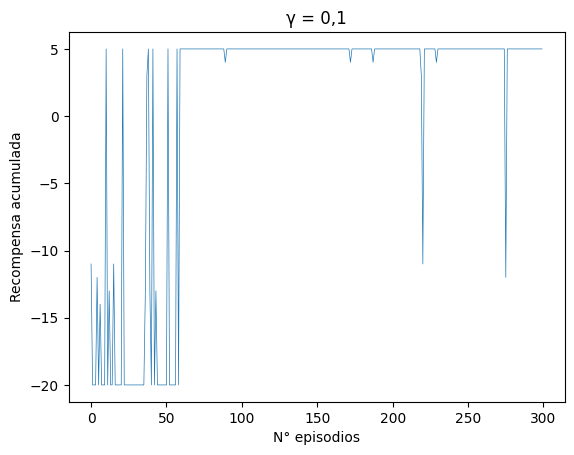

In [ ]:
#0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,1')
plt.show()

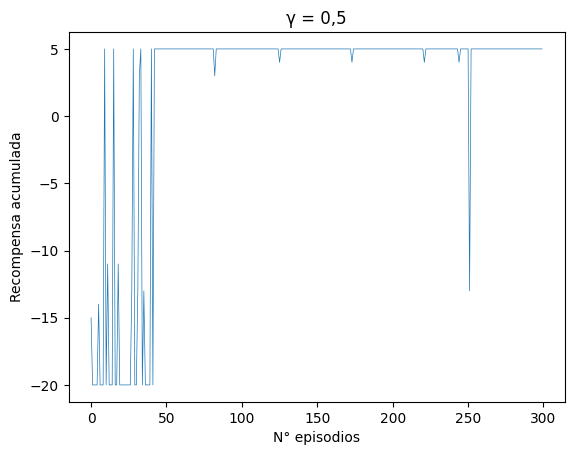

In [ ]:
#0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,5')
plt.show()

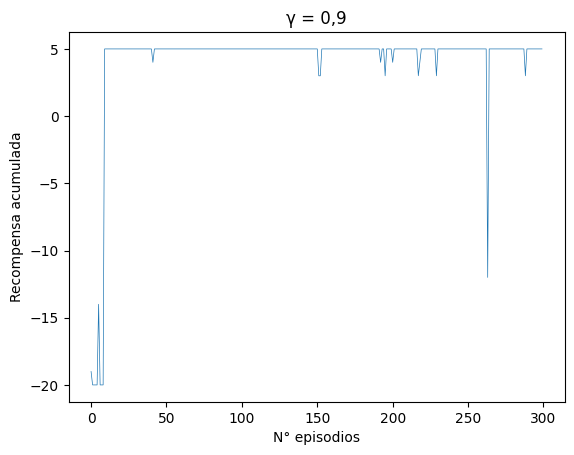

In [ ]:
#0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,9')
plt.show()

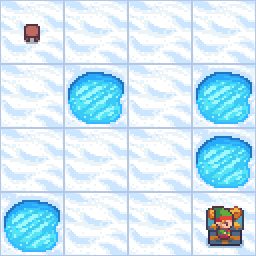

In [ ]:
reward = mc.run_greedily()

# Episodio 2 - Ambiente personalizado 8x8

In [ ]:
class QLearner:

    def __init__(self, environment_name='FrozenLake-v1'):

        self.__environment_name = environment_name
        self.__environment = gym.make(self.__environment_name, desc=None, map_name="8x8", render_mode="ansi", is_slippery=False)
        #self.__environment = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="ansi", is_slippery=False)

        # initializing the Q-table
        self.__Q = []

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

    # train the Q-learning agent
    def train(self, num_episodes=100, num_steps=100, alpha=0.3, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0, min_epsilon=0.0):

        # initializing the Q-table
        self.__Q = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

        # episodes
        for episode in range(num_episodes):

            # reset the environment to start a new episode
            state, info = self.__environment.reset()

            # reward accumulated along episode
            accumulated_reward = 0

            # steps within current episode
            for step in range(num_steps):

                # epsilon-greedy action selection
                # exploit with probability 1-epsilon
                if np.random.uniform(0, 1) > epsilon:
                    action = np.argmax(self.__Q[state,:])

                # explore with probability epsilon
                else:
                    action = self.__environment.action_space.sample()

                # perform the action and observe the new state and corresponding reward
                new_state, reward, terminated, truncated, info = self.__environment.step(action)

                # Ajustes de recompensas
                # Verificar se o novo estado é um buraco (por exemplo, usando a informação 'done' do ambiente)
                if terminated and reward == 0:
                    # Se caiu no buraco, ajuste a recompensa para -50
                    reward = -20
                elif terminated and reward == 1:
                    # Atinjingo o objetivo, a recompensa é 100
                    reward = 20
                else:
                    # Caso contrário, configure a recompensa para -1 a cada passo
                    reward = -1

                # update the Q-table
                self.__Q[state, action] = self.__Q[state, action] + alpha * (reward + gamma * np.max(self.__Q[new_state, :]) - self.__Q[state, action])

                # update the accumulated reward
                accumulated_reward += reward

                # update the current state
                state = new_state

                # end the episode when it is done
                if terminated or truncated:
                    break

            # decay exploration rate to ensure that the agent exploits more as it becomes experienced
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*episode)

            # update the lists of rewards and epsilons
            self.__rewards.append(accumulated_reward)
            self.__epsilons.append(epsilon)

        # return the list of accumulated reward along episodes
        print("Tabela Q:")
        print("[esq, dir, cima, baixo]")
        print(self.__Q)

        return self.__rewards


    # run the Q-learning agent greedily w.r.t. its Q-values
    def run_greedily(self, num_steps=100):

        env = gym.make(self.__environment_name, desc=None, map_name="8x8", render_mode="human", is_slippery=False)
        #env = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="human", is_slippery=False)

        # reset the environment to start a new episode
        state, info = env.reset()

        # reward accumulated along episode
        accumulated_reward = 0

        # steps within current episode
        for step in range(num_steps):

            # act greedily
            action = np.argmax(self.__Q[state,:])

            # perform the action and observe the new state and corresponding reward
            new_state, reward, terminated, truncated, info = env.step(action)

            # update the accumulated reward
            accumulated_reward += reward

            # update the current state
            state = new_state

            # render the environment
            render(env)

            # end the episode when it is done
            if terminated or truncated:
                break

        # return accumulated reward
        return accumulated_reward


In [ ]:
#0,1/0,1  0,5/0,1   0,9/0,1
#0,1/0,5  0,5/0,5   0,9/0,5
#0,1/0,9  0,5/0,9   0,9/0,9

num_episodes=400
num_steps=50

alpha=0.9 #taxa de aprendizado 0, 0.1, 0.3, 0.5, 1 #Cenarios: 0,1 , 0,5 , 0,9
gamma=0.9 #fator de desconto #Cenarios: 0,1 , 0,5 , 0,9

epsilon=1 #taxa de exploração inicia
decay_epsilon=0.0025 #taxa de decaimento da taxa de exploração (ex 0.1 indica que a cada interação o epsilon decai 10%)
min_epsilon=0

# instantiate the Q-learner
ql = QLearner('FrozenLake-v1')

# train the Q-learner
rewards = ql.train(num_episodes, num_steps, alpha, gamma, epsilon, decay_epsilon, min_epsilon)

# print results
print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
print ("Average reward (last 100 episodes): " + str(sum(rewards[-100:])/100))

Tabela Q:
[esq, dir, cima, baixo]
[[ -6.49486552  -6.52007641  -2.37440252  -6.77524513]
 [ -6.28010376  -6.28260142  -1.52711391  -6.45631333]
 [ -5.98524721  -5.81885888  -0.58568212  -6.10583882]
 [ -5.65941503   0.4603532   -5.3469191   -5.720702  ]
 [ -5.33794528  -5.00897298  -4.87650393  -4.88349804]
 [ -4.76135775  -4.86666088  -4.46726529  -4.83238981]
 [ -4.86990401  -4.33678135  -4.32130838  -4.32130748]
 [ -4.16580045  -4.34239677  -4.32130748  -4.32130748]
 [ -6.49486552  -6.38708765  -6.23339518  -6.26922535]
 [ -5.92957551  -6.0299724   -1.75474192  -6.41995539]
 [ -5.74923455  -5.82797339   0.33723753  -5.74110668]
 [ -5.51227458 -18.           1.62261467  -4.96707297]
 [ -4.84674781  -4.88685075   2.9140163   -4.83230405]
 [ -4.81017174   4.348907    -4.36921422  -4.46015754]
 [ -4.70869429  -3.90394341  -4.32253042  -4.36632688]
 [ -4.2216156   -3.99010265  -4.32130748  -4.44767027]
 [ -6.10583882  -6.0891673   -6.11485344  -6.48164324]
 [ -6.22895885  -5.88833882  -6

Para avaliar o desempenho do algoritmo, podemos criar um gráfico da recompensa total por episódio.

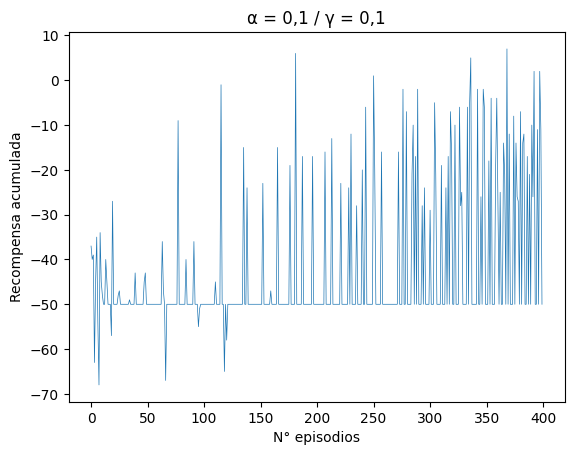

In [ ]:
#0,1/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,1')
plt.show()

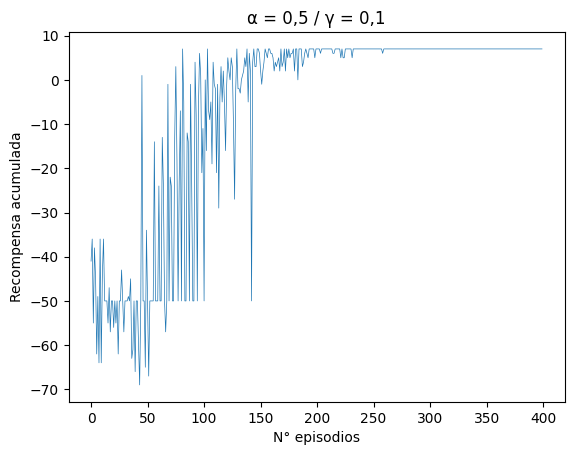

In [ ]:
#0,5/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,1')
plt.show()

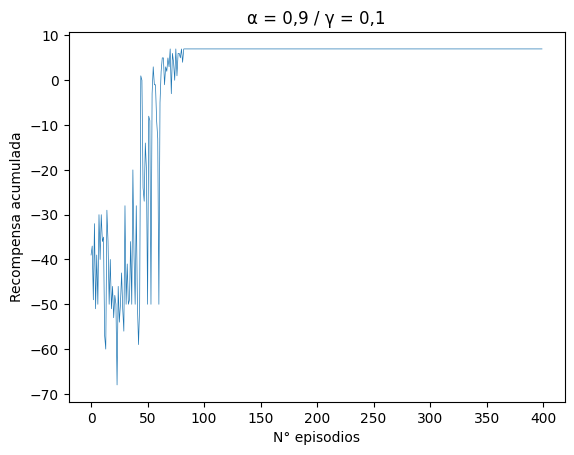

In [ ]:
#0,9/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,1')
plt.show()

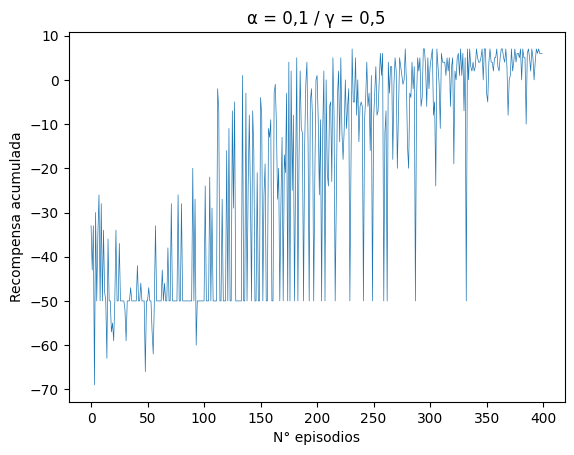

In [ ]:
#0,1/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,5')
plt.show()

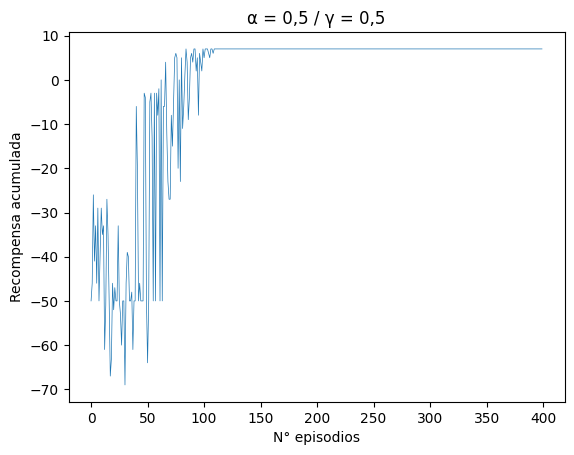

In [ ]:
#0,5/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,5')
plt.show()

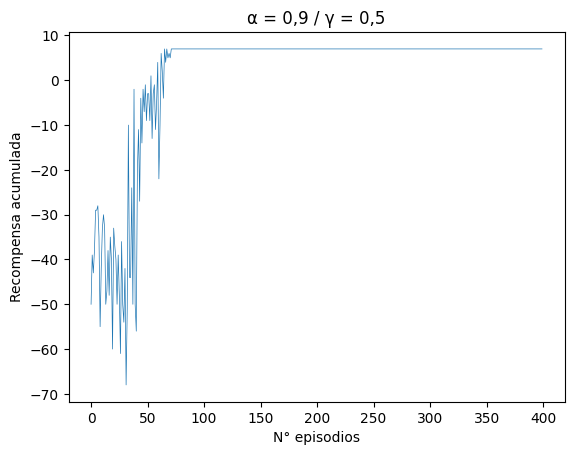

In [ ]:
#0,9/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,5')
plt.show()

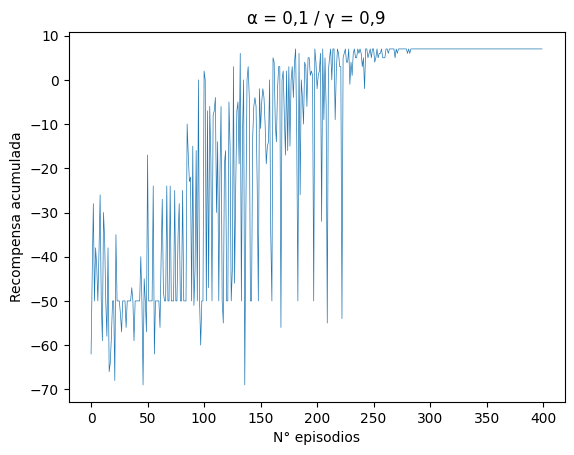

In [ ]:
#0,1/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,9')
plt.show()

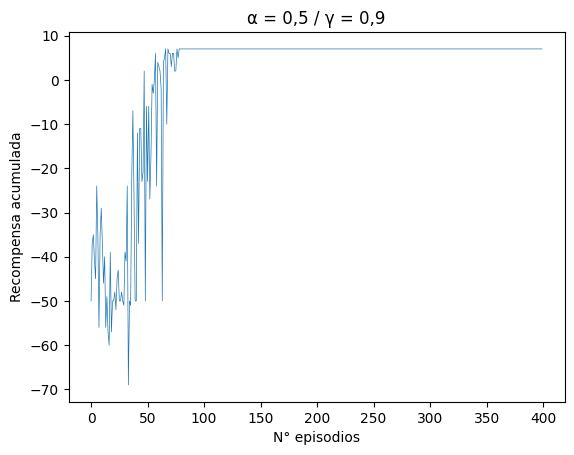

In [ ]:
#0,5/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,9')
plt.show()

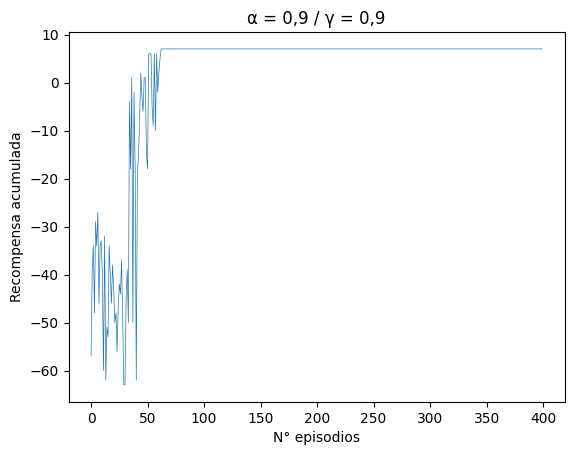

In [ ]:
#0,9/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,9')
plt.show()

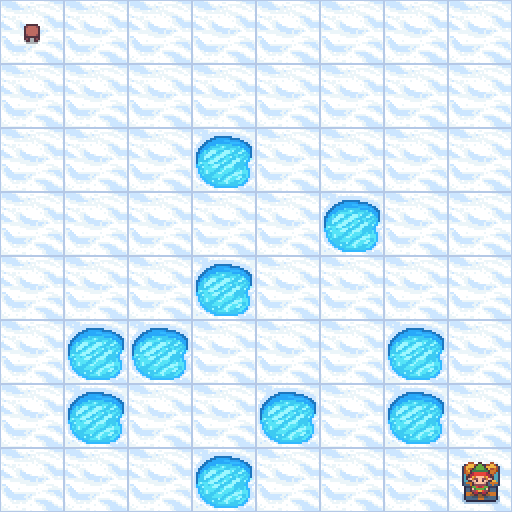

In [ ]:
reward = ql.run_greedily()

Aplicação método de Monte Carlo

In [ ]:
class MonteCarlo:

    def __init__(self, environment_name='FrozenLake-v1'):

        self.__environment_name = environment_name
        self.__environment = gym.make(self.__environment_name, desc=None, map_name="8x8", render_mode="ansi", is_slippery=False)
        #self.__environment = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="ansi", is_slippery=False)

        # initializing the Q-table
        self.__Q = []

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

    def train(self, num_episodes=100, num_steps=100, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0, min_epsilon=0.01):
        # Initialize the Q-table for the target policy
        self.__Q = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # Initialize C(s, a), which is the cumulative sum of importance sampling ratios
        C = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # Initialize the list to store cumulative rewards
        self.__rewards = []

        # Main loop for episodes
        for episode in range(num_episodes):
            state, _ = self.__environment.reset()
            accumulated_reward = 0
            trajectory = []

            # Step within the episode
            for step in range(num_steps):
                # epsilon-greedy action selection
                # exploit with probability 1-epsilon
                if np.random.uniform(0, 1) > epsilon:
                    action = np.argmax(self.__Q[state,:])

                # explore with probability epsilon
                else:
                    action = self.__environment.action_space.sample()

                new_state, reward, terminated, truncated, info = self.__environment.step(action)

                # Ajustes de recompensas
                # Verificar se o novo estado é um buraco
                if terminated and reward == 0:
                    # Se caiu no buraco, ajuste a recompensa para -50
                    reward = -20
                elif terminated and reward == 1:
                    # Atinjindo o objetivo, a recompensa é 100
                    reward = 20
                else:
                    # Caso contrário, configura a recompensa para -1 a cada passo
                    reward = -1

                trajectory.append((state, action, reward))

                accumulated_reward += reward
                if terminated or truncated:
                    break

                state = new_state

            G = 0
            W = 1

            # Update Q_target using Monte Carlo Off-Policy updates
            # Atualiza os valores apenas ao final de cada episódio
            for t in range(len(trajectory) - 1, -1, -1):
                state, action, reward = trajectory[t]
                G = gamma * G + reward
                C[state, action] += W
                self.__Q[state, action] += (W / C[state, action]) * (G - self.__Q[state, action])

                if action != np.argmax(self.__Q[state, :]):
                    break
                W = W / epsilon + 1 - epsilon
                #W = W * 1./behavior_policy(state)[action]

            self.__rewards.append(accumulated_reward)

            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*episode)

        print("Tabela Q:")
        print("[esq, dir, cima, baixo]")
        print(self.__Q)

        # Return the learned Q-values and cumulative rewards
        return self.__rewards

    # run the Q-learning agent greedily w.r.t. its Q-values
    def run_greedily(self, num_steps=100):

        env = gym.make(self.__environment_name, desc=None, map_name="8x8", render_mode="human", is_slippery=False)
        #env = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="human", is_slippery=False)

        # reset the environment to start a new episode
        state, info = env.reset()

        # reward accumulated along episode
        accumulated_reward = 0

        # steps within current episode
        for step in range(num_steps):

            # act greedily
            action = np.argmax(self.__Q[state,:])

            # perform the action and observe the new state and corresponding reward
            new_state, reward, terminated, truncated, info = env.step(action)

            # update the accumulated reward
            accumulated_reward += reward

            # update the current state
            state = new_state

            # render the environment
            render(env)

            # end the episode when it is done
            if terminated or truncated:
                break

        # return accumulated reward
        return accumulated_reward

In [ ]:
num_episodes=1000
num_steps=50
#alpha=0.3
gamma=0.9
epsilon=1
decay_epsilon=0.0025
min_epsilon=0

# instantiate the Q-learner
mc = MonteCarlo('FrozenLake-v1')

# train the Q-learner
rewards = mc.train(num_episodes, num_steps, gamma, epsilon, decay_epsilon, min_epsilon)

# print results
#print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
#print ("Average reward (last 100 episodes): " + str(sum(rewards[-100:])/100))

Tabela Q:
[esq, dir, cima, baixo]
[[ -3.13696226  -2.37440252  -2.37440252  -2.70732931]
 [ -2.70992212  -1.52711391  -1.52711391  -1.89360368]
 [ -1.9         -0.58568212  -0.58568212  -1.        ]
 [ -1.           0.4603532    0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [ -2.37440252  -1.52711391  -1.52711391  -2.7099622 ]
 [ -2.37440252  -0.58568212  -0.58568212  -1.9       ]
 [ -1.           0.4603532    0.           0.        ]
 [ -0.58568212 -20.           1.62261467   0.        ]
 [ -1.           2.9140163    0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [ -2.70689147  -2.37440252  -0.58568212  -2.37440252]
 [ -2.70997392   0.4603532    0

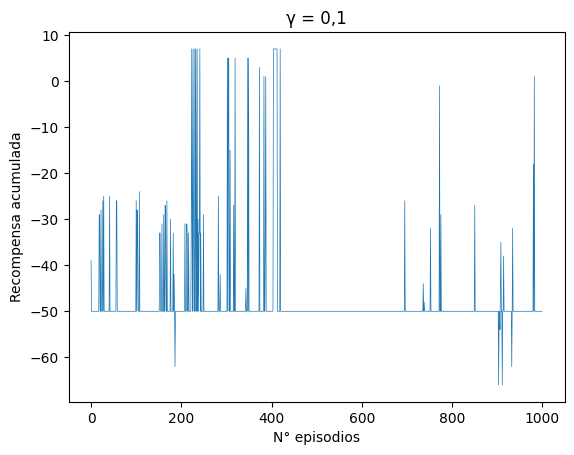

In [ ]:
#0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,1')
plt.show()

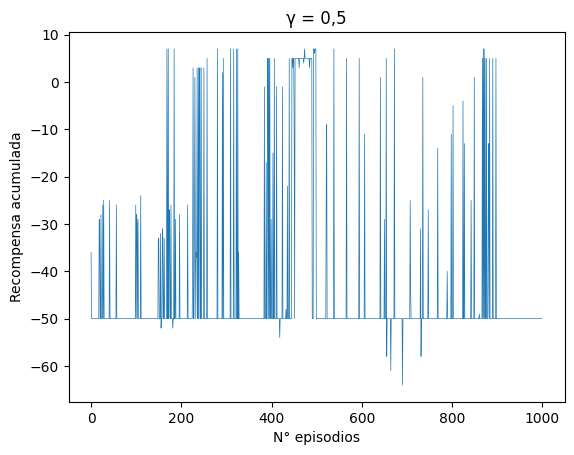

In [ ]:
#0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,5')
plt.show()

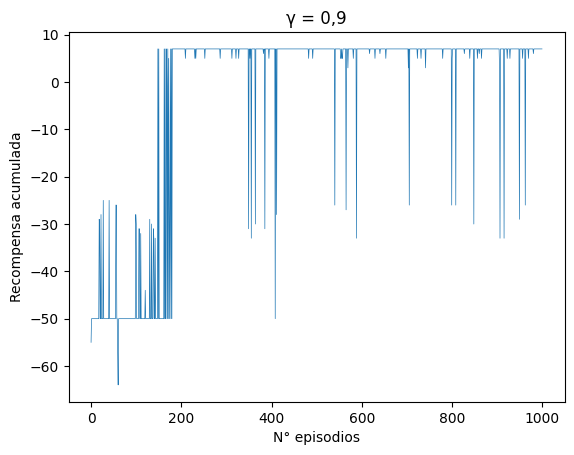

In [ ]:
#0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,9')
plt.show()

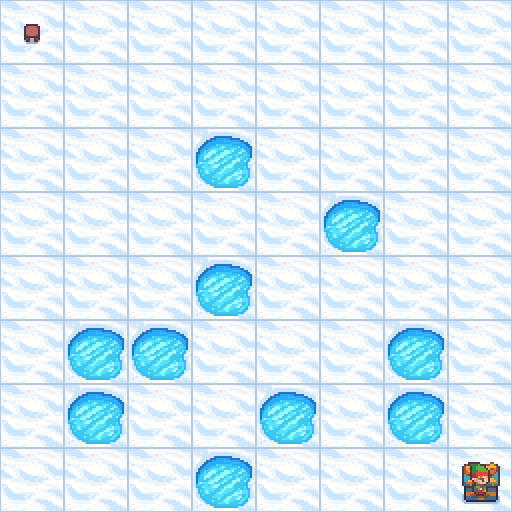

In [ ]:
reward = mc.run_greedily()

# Episodio 3 - Ambiente personalizado 16x16

In [ ]:
class QLearner:

    def __init__(self, environment_name='FrozenLake-v1'):

        self.__environment_name = environment_name
        #self.__environment = gym.make(self.__environment_name, desc=None, map_name="8x8", render_mode="ansi", is_slippery=False)
        self.__environment = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="ansi", is_slippery=False)

        # initializing the Q-table
        self.__Q = []

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

    # train the Q-learning agent
    def train(self, num_episodes=100, num_steps=100, alpha=0.3, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0, min_epsilon=0.0):

        # initializing the Q-table
        self.__Q = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

        # episodes
        for episode in range(num_episodes):

            # reset the environment to start a new episode
            state, info = self.__environment.reset()

            # reward accumulated along episode
            accumulated_reward = 0

            # steps within current episode
            for step in range(num_steps):

                # epsilon-greedy action selection
                # exploit with probability 1-epsilon
                if np.random.uniform(0, 1) > epsilon:
                    action = np.argmax(self.__Q[state,:])

                # explore with probability epsilon
                else:
                    action = self.__environment.action_space.sample()

                # perform the action and observe the new state and corresponding reward
                new_state, reward, terminated, truncated, info = self.__environment.step(action)

                # Ajustes de recompensas
                # Verificar se o novo estado é um buraco (por exemplo, usando a informação 'done' do ambiente)
                if terminated and reward == 0:
                    # Se caiu no buraco, ajuste a recompensa para -50
                    reward = -50
                elif terminated and reward == 1:
                    # Atinjingo o objetivo, a recompensa é 100
                    reward = 50
                else:
                    # Caso contrário, configure a recompensa para -1 a cada passo
                    reward = -1

                # update the Q-table
                self.__Q[state, action] = self.__Q[state, action] + alpha * (reward + gamma * np.max(self.__Q[new_state, :]) - self.__Q[state, action])

                # update the accumulated reward
                accumulated_reward += reward

                # update the current state
                state = new_state

                # end the episode when it is done
                if terminated or truncated:
                    break

            # decay exploration rate to ensure that the agent exploits more as it becomes experienced
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*episode)

            # update the lists of rewards and epsilons
            self.__rewards.append(accumulated_reward)
            self.__epsilons.append(epsilon)

        # return the list of accumulated reward along episodes
        print("Tabela Q:")
        print("[esq, dir, cima, baixo]")
        print(self.__Q)

        return self.__rewards


    # run the Q-learning agent greedily w.r.t. its Q-values
    def run_greedily(self, num_steps=100):

        #env = gym.make(self.__environment_name, desc=None, map_name="8x8", render_mode="human", is_slippery=False)
        env = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="human", is_slippery=False)

        # reset the environment to start a new episode
        state, info = env.reset()

        # reward accumulated along episode
        accumulated_reward = 0

        # steps within current episode
        for step in range(num_steps):

            # act greedily
            action = np.argmax(self.__Q[state,:])

            # perform the action and observe the new state and corresponding reward
            new_state, reward, terminated, truncated, info = env.step(action)

            # update the accumulated reward
            accumulated_reward += reward

            # update the current state
            state = new_state

            # render the environment
            render(env)

            # end the episode when it is done
            if terminated or truncated:
                break

        # return accumulated reward
        return accumulated_reward


In [ ]:
#0,1/0,1  0,5/0,1   0,9/0,1
#0,1/0,5  0,5/0,5   0,9/0,5
#0,1/0,9  0,5/0,9   0,9/0,9

num_episodes=1000
num_steps=100

alpha=0.5 #taxa de aprendizado 0, 0.1, 0.3, 0.5, 1 #Cenarios: 0,1 , 0,5 , 0,9
gamma=0.9 #fator de desconto #Cenarios: 0,1 , 0,5 , 0,9

epsilon=1 #taxa de exploração inicia
decay_epsilon=0.001 #taxa de decaimento da taxa de exploração (ex 0.1 indica que a cada interação o epsilon decai 10%)
min_epsilon=0

# instantiate the Q-learner
ql = QLearner('FrozenLake-v1')

# train the Q-learner
rewards = ql.train(num_episodes, num_steps, alpha, gamma, epsilon, decay_epsilon, min_epsilon)

# print results
print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
print ("Average reward (last 100 episodes): " + str(sum(rewards[-100:])/100))

Tabela Q:
[esq, dir, cima, baixo]
[[ -9.10255168  -9.09592714  -7.71087745  -9.10255168]
 [ -9.04733719  -9.00337832  -7.4565305   -9.00559743]
 [ -8.93455196 -25.          -7.17392278  -8.8981689 ]
 ...
 [ -1.18875     -0.975       43.99349213 -25.        ]
 [ -0.5         -0.5         49.99961853   0.        ]
 [  0.           0.           0.           0.        ]]
Average reward (all episodes): -10.798
Average reward (last 100 episodes): 19.0


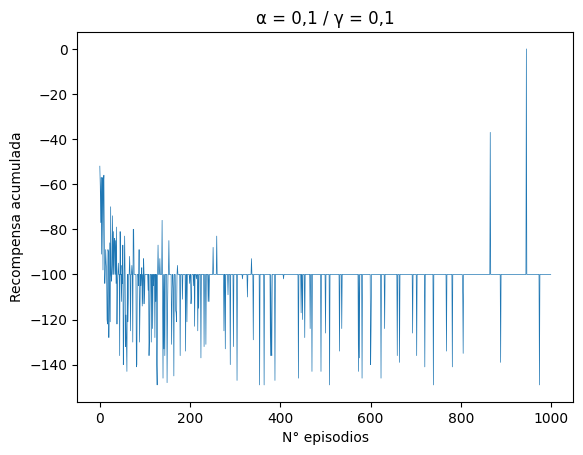

In [ ]:
#0,1/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,1')
plt.show()

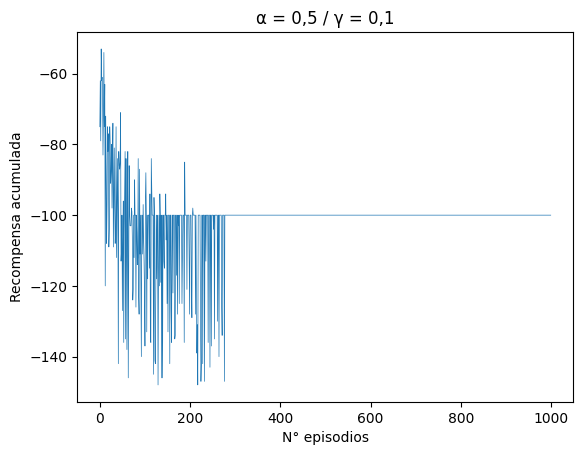

In [ ]:
#0,5/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,1')
plt.show()

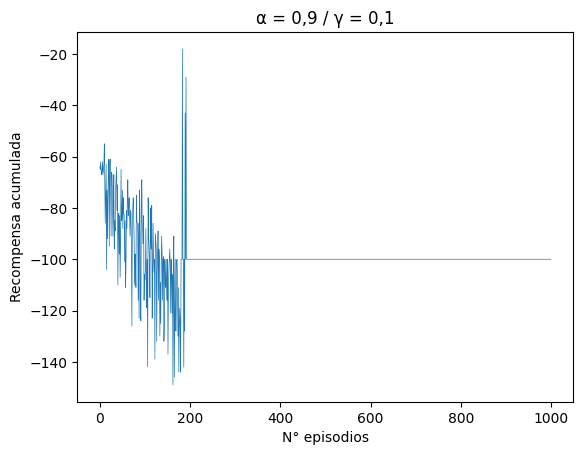

In [ ]:
#0,9/0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,1')
plt.show()

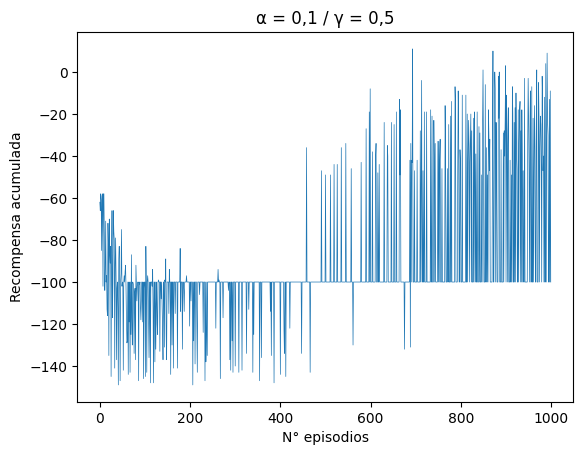

In [ ]:
#0,1/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,5')
plt.show()

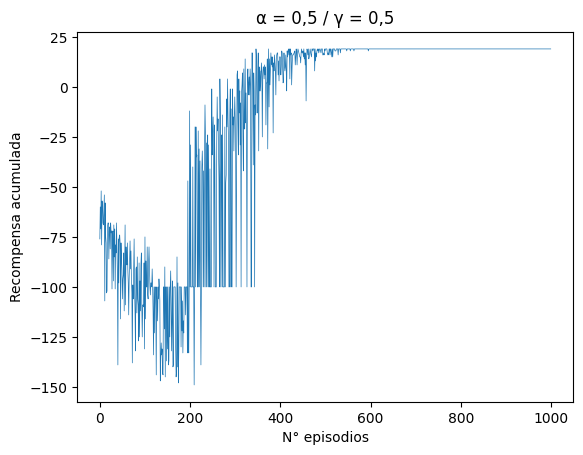

In [ ]:
#0,5/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,5')
plt.show()

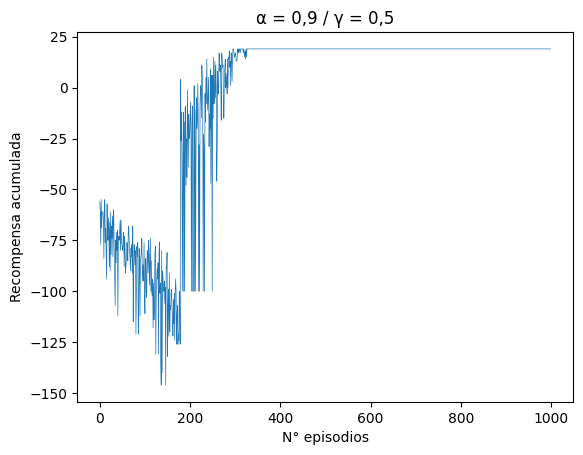

In [ ]:
#0,9/0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,5')
plt.show()

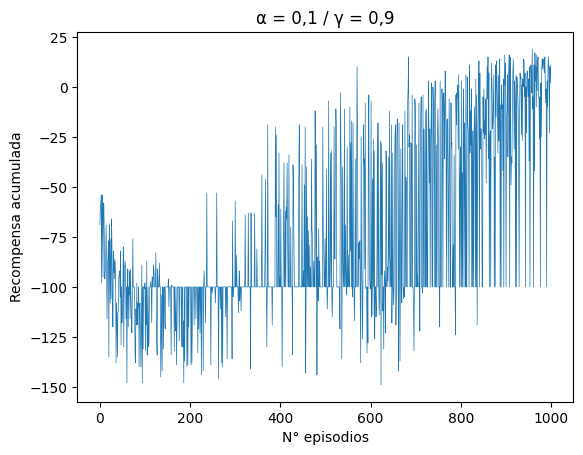

In [ ]:
#0,1/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,1 / γ = 0,9')
plt.show()

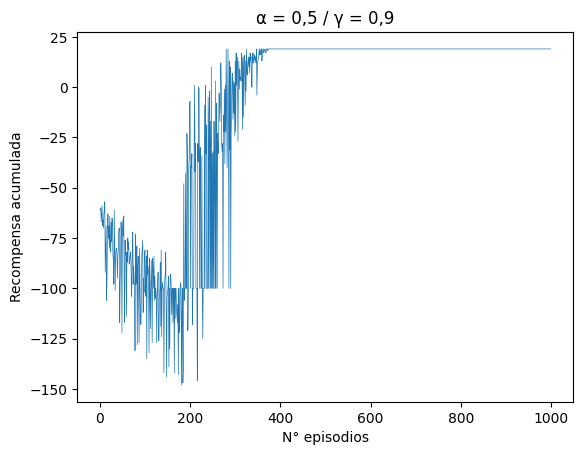

In [ ]:
#0,5/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,5 / γ = 0,9')
plt.show()

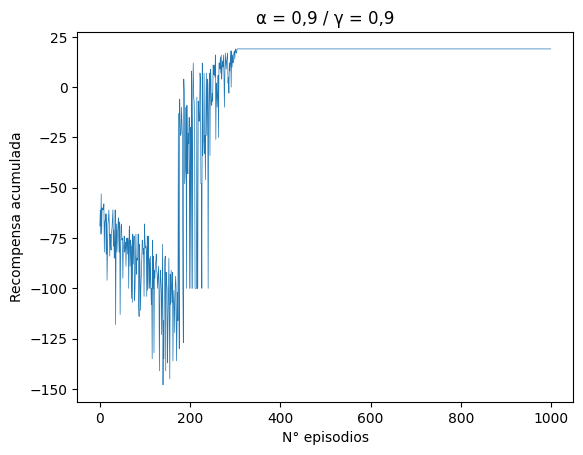

In [ ]:
#0,9/0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('α = 0,9 / γ = 0,9')
plt.show()

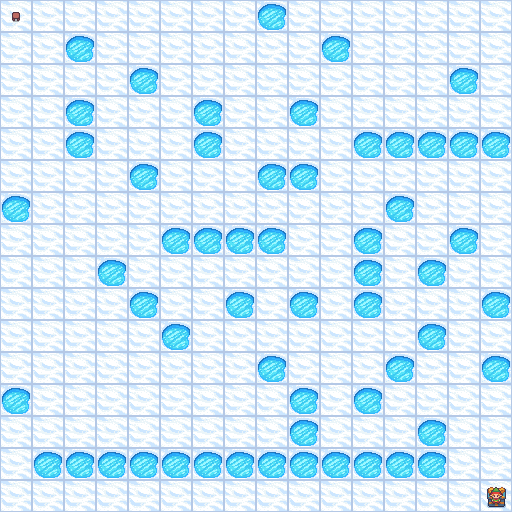

In [ ]:
reward = ql.run_greedily()

Aplicação método de monte carlo

In [ ]:
class MonteCarlo:

    def __init__(self, environment_name='FrozenLake-v1'):

        self.__environment_name = environment_name
        #self.__environment = gym.make(self.__environment_name, desc=None, map_name="8x8", render_mode="ansi", is_slippery=False)
        self.__environment = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="ansi", is_slippery=False)

        # initializing the Q-table
        self.__Q = []

        # additional lists to keep track of reward and epsilon values
        self.__rewards = []
        self.__epsilons = []

    def train(self, num_episodes=100, num_steps=100, gamma=0.9, epsilon=1.0, decay_epsilon=0.1, max_epsilon=1.0, min_epsilon=0.01):
        # Initialize the Q-table for the target policy
        self.__Q = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # Initialize C(s, a), which is the cumulative sum of importance sampling ratios
        C = np.zeros((self.__environment.observation_space.n, self.__environment.action_space.n))

        # Initialize the list to store cumulative rewards
        self.__rewards = []

        # Main loop for episodes
        for episode in range(num_episodes):
            state, _ = self.__environment.reset()
            accumulated_reward = 0
            trajectory = []

            # Step within the episode
            for step in range(num_steps):
                # epsilon-greedy action selection
                # exploit with probability 1-epsilon
                if np.random.uniform(0, 1) > epsilon:
                    action = np.argmax(self.__Q[state,:])

                # explore with probability epsilon
                else:
                    action = self.__environment.action_space.sample()

                new_state, reward, terminated, truncated, info = self.__environment.step(action)

                # Ajustes de recompensas
                # Verificar se o novo estado é um buraco
                if terminated and reward == 0:
                    # Se caiu no buraco, ajuste a recompensa para -50
                    reward = -50
                elif terminated and reward == 1:
                    # Atinjindo o objetivo, a recompensa é 100
                    reward = 50
                else:
                    # Caso contrário, configura a recompensa para -1 a cada passo
                    reward = -1

                trajectory.append((state, action, reward))

                accumulated_reward += reward
                if terminated or truncated:
                    break

                state = new_state

            G = 0
            W = 1

            # Update Q_target using Monte Carlo Off-Policy updates
            # Atualiza os valores apenas ao final de cada episódio
            for t in range(len(trajectory) - 1, -1, -1):
                state, action, reward = trajectory[t]
                G = gamma * G + reward
                C[state, action] += W
                self.__Q[state, action] += (W / C[state, action]) * (G - self.__Q[state, action])

                if action != np.argmax(self.__Q[state, :]):
                    break
                W = W / epsilon + 1 - epsilon
                #W = W * 1./behavior_policy(state)[action]

            self.__rewards.append(accumulated_reward)

            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_epsilon*episode)

        print("Tabela Q:")
        print("[esq, dir, cima, baixo]")
        print(self.__Q)

        # Return the learned Q-values and cumulative rewards
        return self.__rewards

    # run the Q-learning agent greedily w.r.t. its Q-values
    def run_greedily(self, num_steps=100):

        #env = gym.make(self.__environment_name, desc=None, map_name="8x8", render_mode="human", is_slippery=False)
        env = gym.make(self.__environment_name, desc=descFrozenLake, render_mode="human", is_slippery=False)

        # reset the environment to start a new episode
        state, info = env.reset()

        # reward accumulated along episode
        accumulated_reward = 0

        # steps within current episode
        for step in range(num_steps):

            # act greedily
            action = np.argmax(self.__Q[state,:])

            # perform the action and observe the new state and corresponding reward
            new_state, reward, terminated, truncated, info = env.step(action)

            # update the accumulated reward
            accumulated_reward += reward

            # update the current state
            state = new_state

            # render the environment
            render(env)

            # end the episode when it is done
            if terminated or truncated:
                break

        # return accumulated reward
        return accumulated_reward

In [ ]:
num_episodes=30000
num_steps=100
#alpha=0.3
gamma=0.9
epsilon=1
decay_epsilon=0.001
min_epsilon=0

# instantiate the Q-learner
mc = MonteCarlo('FrozenLake-v1')

# train the Q-learner
rewards = mc.train(num_episodes, num_steps, gamma, epsilon, decay_epsilon, min_epsilon)

# print results
#print ("Average reward (all episodes): " + str(sum(rewards)/num_episodes))
#print ("Average reward (last 100 episodes): " + str(sum(rewards[-100:])/100))

Tabela Q:
[esq, dir, cima, baixo]
[[ -9.31326324  -9.23695915  -9.23695915  -9.31326324]
 [ -9.19968076  -9.15217683  -9.15217683  -9.20142058]
 [ -9.20226044 -10.          -9.05797426  -9.11268954]
 ...
 [  4.57998288   6.19998172   8.         -10.        ]
 [  6.2          8.          10.           6.2       ]
 [  0.           0.           0.           0.        ]]


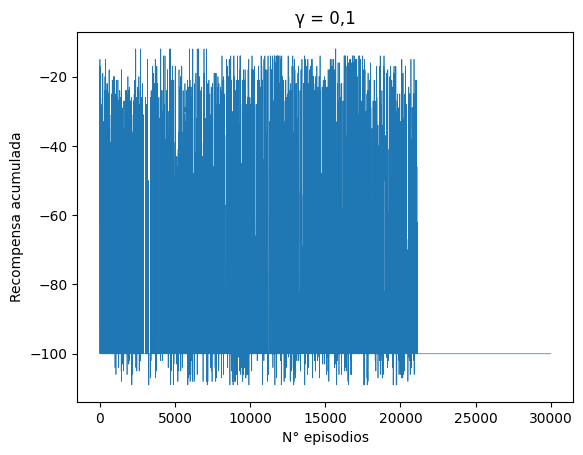

In [ ]:
#0,1
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,1')
plt.show()

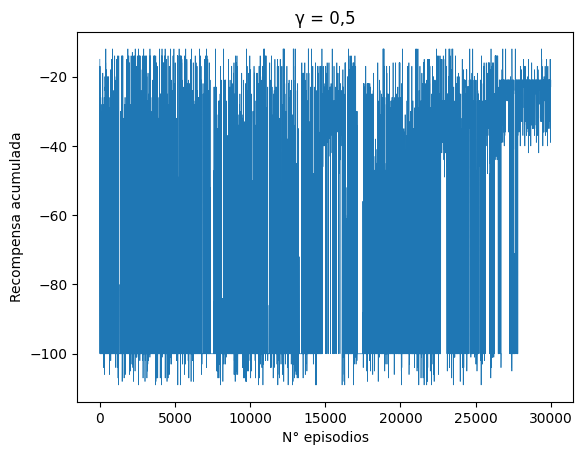

In [ ]:
#0,5
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,5')
plt.show()

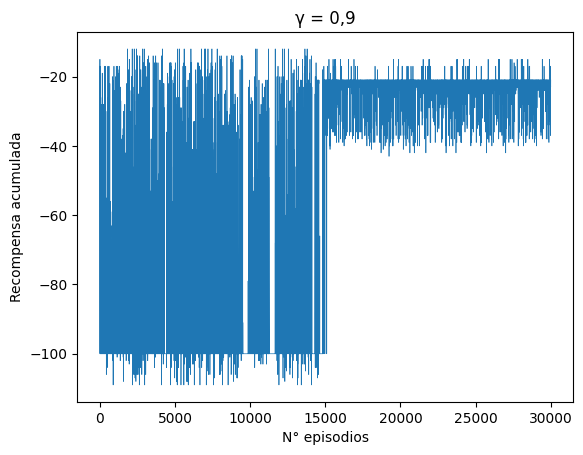

In [ ]:
#0,9
plt.plot(range(num_episodes), rewards, linewidth=0.5)
plt.xlabel('N° episodios')
plt.ylabel('Recompensa acumulada')
plt.title('γ = 0,9')
plt.show()

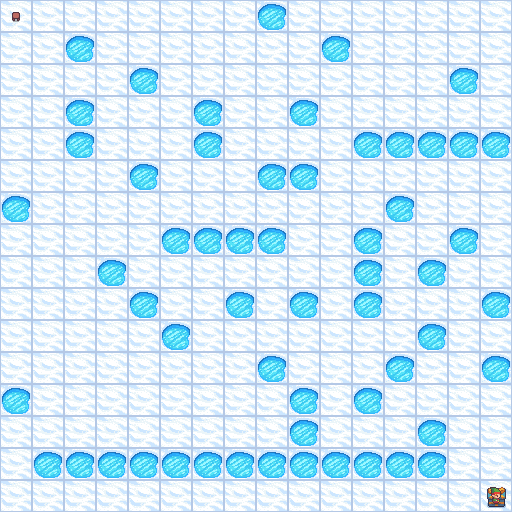

In [ ]:
reward = mc.run_greedily()